In [1]:
from sklearn.metrics import log_loss
from sklearn.utils.extmath import squared_norm
from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise
import numpy as np
import sklearn
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss
from sklearn.utils.extmath import squared_norm
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier
from sklearn.linear_model import LogisticRegression
import optuna
import pandas as pd
from scipy import stats
import math

import sys
sys.path.append("./MMFP/")
from MMPF.MinimaxParetoFair.MMPF_trainer import SKLearn_Weighted_LLR, APSTAR

import pandas as pd
import math
import random
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss, accuracy_score
from sklearn.utils.extmath import squared_norm
import optuna, sklearn, sklearn.datasets

from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise

from fair_models import coefficient_of_variation, MOOLogisticRegression, FindCLogisticRegression, FindCCLogisticRegression
from fair_models import calc_reweight
from fair_models import FairScalarization, EqualScalarization
from fair_models import SimpleVoting

import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import sys
sys.path.append("./MMFP/")
from MMPF.MinimaxParetoFair.MMPF_trainer import SKLearn_Weighted_LLR, APSTAR

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import matplotlib.pyplot as plt
import math

In [3]:
class ImageScalarization(w_interface, single_interface, scalar_interface):
    def __init__(self, X, y, fair_feat):
        self.fair_feat = fair_feat
        self.fair_att = sorted(X[fair_feat].unique())
        self.__M = len(self.fair_att)
        self.X, self.y = X, y

    @property
    def M(self):
        return self.__M

    @property
    def feasible(self):
        return True

    @property
    def optimum(self):
        return True

    @property
    def objs(self):
        return self.__objs

    @property
    def x(self):
        return self.__x

    @property
    def w(self):
        return self.__w

    def optimize(self, w):
        """Calculates the a multiobjective scalarization"""
        if type(w) is int:
            self.__w = np.zeros(self.M)
            self.__w[w] = 1
        elif type(w) is np.ndarray and w.ndim==1 and w.size==self.M:
            self.__w = w
        else:
            raise('w is in the wrong format')
        #print('w', self.__w)
            
        lambd = math.exp(-20)
        fair_weight = self.__w
        
        sample_weight = self.X[self.fair_feat].replace({ff:fw/sum(self.X[self.fair_feat]==ff) for ff, fw in zip(self.fair_att,fair_weight)})
        prec = np.mean(sample_weight)
        reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=None,
                                 penalty='l2', max_iter=10**4, tol=prec*10**-6, 
                                 C=1/lambd).fit(self.X, self.y, sample_weight=sample_weight.values)
        
        y_pred = reg.predict_proba(self.X)
        
        self.__objs = np.zeros(len(self.fair_att))
        for i, feat in enumerate(self.fair_att):
            fair_weight = np.zeros(len(self.fair_att))
            fair_weight[i] = 1
            sample_weight = self.X[self.fair_feat].replace({ff:fw for ff, fw in zip(self.fair_att,fair_weight)})
            self.__objs[i] = log_loss(self.y, y_pred, sample_weight=sample_weight)
        
        self.__x = reg
        return self

In [4]:
data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
fair_feature = "not_white"
pred_feature = "Two_yr_Recidivism"

In [5]:
data = data.drop("Unnamed: 0", axis=1)

In [6]:
categories_fair_class = []

for index, row in data.iterrows():
    if row[pred_feature] == -1:
        categories_fair_class.append(row[fair_feature])
    else:
        categories_fair_class.append(row[fair_feature]+2)

In [7]:
X = data.drop([pred_feature], axis=1)
y = data[pred_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(data.shape[0]*0.2),stratify=categories_fair_class)

In [8]:
X_raca1_train = X_train[X_train[fair_feature] == 1]
y_raca1_train = y_train[X_train[fair_feature] == 1]
X_raca0_train = X_train[X_train[fair_feature] == 0]
y_raca0_train = y_train[X_train[fair_feature] == 0]

In [9]:
X_raca1_test = X_test[X_test[fair_feature] == 1]
y_raca1_test = y_test[X_test[fair_feature] == 1]
X_raca0_test = X_test[X_test[fair_feature] == 0]
y_raca0_test = y_test[X_test[fair_feature] == 0]

In [10]:
err_image = monise(weightedScalar=ImageScalarization(X_train, y_train, fair_feature),
                 singleScalar=ImageScalarization(X_train, y_train, fair_feature),
                  nodeTimeLimit=5, targetSize=150,
                  targetGap=0, nodeGap=0.05, norm=False)

err_image.optimize()

2021-04-29 19:20:28,858 - moopt.monise - DEBUG: Finding 1th individual minima
2021-04-29 19:20:28,915 - moopt.monise - DEBUG: Finding 2th individual minima



--------------------------------------------
--------------------------------------------

Using license file /opt/gurobi/gurobi.lic
Academic license - for non-commercial use only


2021-04-29 19:20:29,045 - moopt.monise - DEBUG: 3th solution - importance: 1.0
2021-04-29 19:20:29,113 - moopt.monise - DEBUG: 4th solution - importance: 1.0
2021-04-29 19:20:29,222 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-04-29 19:20:29,290 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-04-29 19:20:29,364 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-04-29 19:20:29,445 - moopt.monise - DEBUG: 8th solution - importance: 0.32020799112082793
2021-04-29 19:20:29,529 - moopt.monise - DEBUG: 9th solution - importance: 0.10847193746273583
2021-04-29 19:20:29,605 - moopt.monise - DEBUG: 10th solution - importance: 0.08549316334059884
2021-04-29 19:20:29,690 - moopt.monise - DEBUG: 11th solution - importance: 0.07499144745231186
2021-04-29 19:20:29,778 - moopt.monise - DEBUG: 12th solution - importance: 0.04590401067630497
2021-04-29 19:20:29,866 - moopt.monise - DEBUG: 13th solution - importance: 0.021768170638072452
2021-04-29 19:20:29,971 - moop

2021-04-29 19:20:53,379 - moopt.monise - DEBUG: 87th solution - importance: 0.00035031095647481965
2021-04-29 19:20:54,045 - moopt.monise - DEBUG: 88th solution - importance: 0.00035031095647481965
2021-04-29 19:20:54,740 - moopt.monise - DEBUG: 89th solution - importance: 0.00035031095647481965
2021-04-29 19:20:55,432 - moopt.monise - DEBUG: 90th solution - importance: 0.0003503109564747959
2021-04-29 19:20:56,130 - moopt.monise - DEBUG: 91th solution - importance: 0.00035031095647481965
2021-04-29 19:20:56,835 - moopt.monise - DEBUG: 92th solution - importance: 0.00035031095647481965
2021-04-29 19:20:57,539 - moopt.monise - DEBUG: 93th solution - importance: 0.00035031095647481965
2021-04-29 19:20:58,280 - moopt.monise - DEBUG: 94th solution - importance: 0.00035031095647481965
2021-04-29 19:20:59,004 - moopt.monise - DEBUG: 95th solution - importance: 0.00035031095647481965
2021-04-29 19:20:59,749 - moopt.monise - DEBUG: 96th solution - importance: 0.00035031095647481965
2021-04-29 

In [11]:
loss = {"Raca1": [], "Raca0": []}

for solution in err_image.solutionsList:
    #sols.append(solution.x)
    #erro['Raca1'].append(solution.x.score(X_raca1_train, y_raca1_train))
    #erro['Raca0'].append(solution.x.score(X_raca0_train, y_raca0_train))
    loss['Raca0'].append(log_loss(y_raca0_train, solution.x.predict_proba(X_raca0_train)))
    loss['Raca1'].append(log_loss(y_raca1_train, solution.x.predict_proba(X_raca1_train)))

In [12]:
loss_dt = pd.DataFrame.from_dict(loss).sort_values(by='Raca0')

In [13]:
fig= plt.figure(figsize=(6,4))

<Figure size 432x288 with 0 Axes>

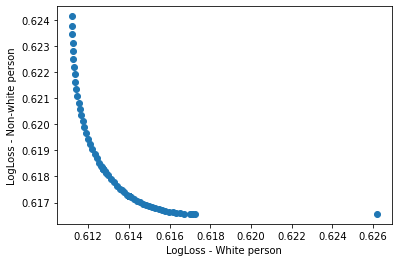

In [17]:
plt.scatter(loss_dt['Raca0'], loss_dt['Raca1'])
#plt.plot(loss_dt['Raca0'], loss_dt['Raca1'])
plt.xlabel('LogLoss - White person')
plt.ylabel('LogLoss - Non-white person')
#plt.title("Conflict between losses for white and non-white person for training data")

plt.savefig("Conflit-LossesProPublica-notitle.png", dpi=300)
plt.show()

In [87]:
import numpy as np

C_values = np.logspace(-100, 100, 500)

loss_reglog = {"White": [], "Non-white": []}

for C in C_values:
    model = LogisticRegression(C=C, max_iter=10**3, tol=10**-6)
    model.fit(X_train, y_train)
    
    loss_reglog['White'].append(log_loss(y_raca0_train, model.predict_proba(X_raca0_train)))
    loss_reglog['Non-white'].append(log_loss(y_raca1_train, model.predict_proba(X_raca1_train)))

In [88]:
loss_reglog_dt = pd.DataFrame.from_dict(loss_reglog).sort_values(by='White')

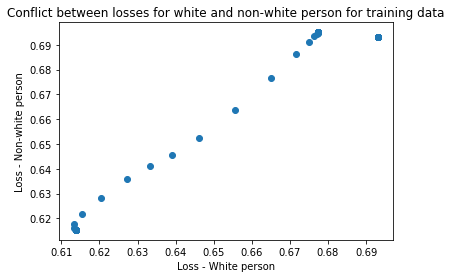

In [89]:
plt.scatter(loss_reglog_dt['White'], loss_reglog_dt['Non-white'])
#plt.plot(loss_dt['Raca0'], loss_dt['Raca1'])
plt.xlabel('Loss - White person')
plt.ylabel('Loss - Non-white person')
plt.title("Conflict between losses for white and non-white person for training data")
plt.show()